# StarGAN

### Загрузка данных
В данном задании вам предстоит работать с CelebA 64x64 и генерировать новые лица с заданными аттрибутами

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1amcPPsQDDmrlbXXErCC-LeF04mjymnDM

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=0baaaa7a071099ea92c896c0b8a858f9a0ee5e267b1d194490c0dd4b6d70bc9b
  Stored in directory: /tmp/pip-ephem-wheel-cache-vx65tm4i/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1amcPPsQDDmrlbXXErCC-LeF04mjymnDM
To: /content/celeba.py
100% 3.25k/3.25k [00:00<00:00, 5.41MB/s]


In [3]:
import requests
# url = 'https://drive.google.com/file/d/1amcPPsQDDmrlbXXErCC-LeF04mjymnDM/view?usp=sharing'
# open('celeba.py', 'wb').write(requests.get(url).content);
url = 'https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/data/celeba/list_attr_celeba.txt'
open('list_attr_celeba.txt', 'wb').write(requests.get(url).content);


In [4]:
from celeba import CelebADataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.auto import trange, tqdm
import gdown

from torch import Tensor

Загрузим человекочитаемые названия доменов

In [5]:
with open('list_attr_celeba.txt', 'r') as f:
    attr_name = np.array(f.readline().split(' ')[:-1])
attr_name

array(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee',
       'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
       'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'], dtype='<U19')

In [6]:
t_normalize = lambda x: x * 2 - 1
t_invnormalize = lambda x: (x + 1) / 2
transform=transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    t_normalize,
])

Мы будем использовать урезанный датасет (`crop=True`) для быстрой загрузки на диск.

Для обучения модели вам нужно будет загрузить полную версию датасета.

Перед отправкой тетрадки в автопроверку ***ПРОВЕРЬТЕ*** что `crop=True`, иначе ваше решение будет таймаутиться

Главная проблема мультидоменной генерации на селебе - наличие большого количества "бесполезных" классов, например 'Arched_Eyebrows', 'Attractive' 'Bags_Under_Eyes итд. Чтобы сделать задачу чуть проще, в этой домашке мы предлагаем вам взять 10 аттрибутов и учить im2im только на них

In [7]:
from random import randint

class CelebaCustomDataset(CelebADataset):
    def __getitem__(self, idx):
        indices = [8, 9, 11, 15, 16, 20, 22, 28, 35, 39]
        image, target = super().__getitem__(idx)
        target = target['attributes'] == 1
        new_target = target[indices]
        if sum(new_target) == 0:
            return self.__getitem__(randint(0, len(self) - 1))
        return image, new_target


In [8]:
attr_name = attr_name[[8, 9, 11, 15, 16, 20, 22, 28, 35, 39]]

In [9]:
dataset = CelebaCustomDataset(
    transform=transform,
    attr_file_path='list_attr_celeba.txt',
    crop=False
)
img, attr = dataset[0]
img.shape

Downloading...
From: https://drive.google.com/uc?id=18pFjIjS3M8VsKpj6BkPt2JeqElhnV4Bh
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:17<00:00, 81.8MB/s]


torch.Size([3, 64, 64])

### Визуализация датасета

In [10]:
def plot_img(img, transform):
    plt.imshow(transform(img).permute(1, 2, 0))
    plt.axis('off')

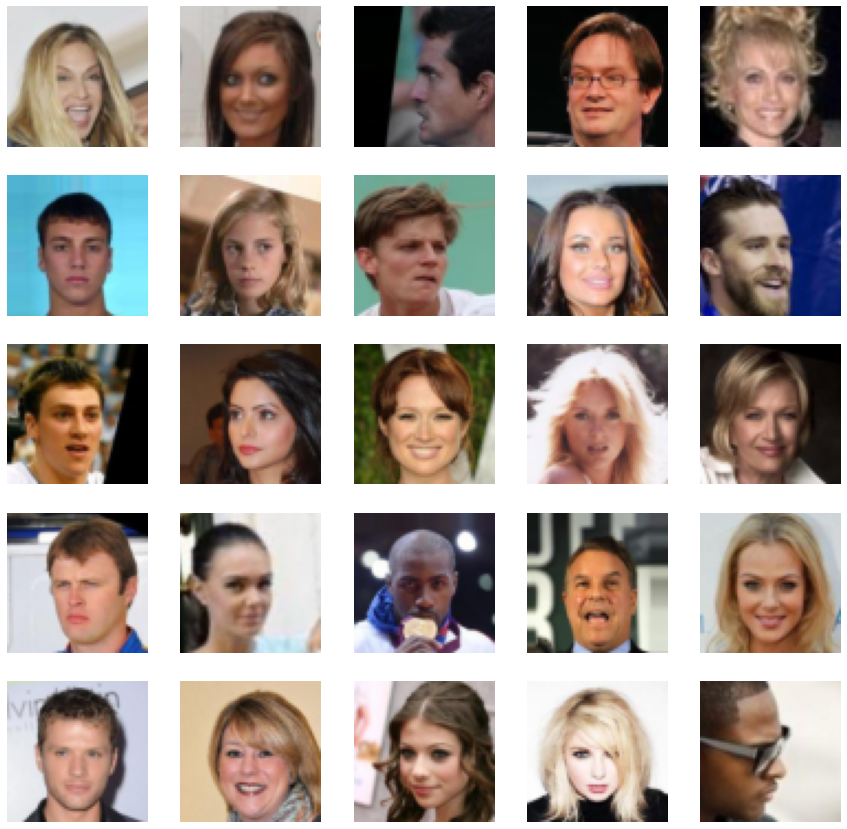

In [11]:
plt.figure(figsize=(15, 15))

for i in range(25):
    img, attr = dataset[np.random.randint(len(dataset))]
    plt.subplot(5, 5, i + 1)
    plot_img(img, t_invnormalize)
plt.show()

### Задача 1 (3/10 балла). Обучите low-res StarGanV1 на ограниченном подмножестве аттрибутов



В рамках данного задания предлагается реализовать и обучить [StarGAN v1](https://arxiv.org/pdf/1711.09020.pdf) для генерации лиц с заданными аттрибутами

<img src='https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/images/stargan_v1.png' width=600>

Вы можете добавлять любые дополнительные  параметры и использовать любые трюки для стабилизации/улучшения обучения на свое усмотрение. -->


In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
        )
    def forward(self, x):
        return x + self.residual(x)

In [13]:
from torch.nn.modules.conv import Conv2d
class Generator(nn.Module):
    def __init__(self, hidden_dim=32, n_c=10):
        """
        you can use any parameters here, for example ->
        hidden_dim: number of channels used in convs 
        """
        super().__init__()
        ### BEGIN SOLUTION
        self.downsample = nn.Sequential(
            nn.Conv2d(3+n_c, 32, 7, 1, 3, bias=False),
            nn.InstanceNorm2d(32, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
        )
        self.bottleneck = nn.Sequential(*[ResidualBlock(128, 128) for i in range(6)])
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(32, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 7, 1, 3, bias=False),
            nn.Tanh(),
        )

        ### END SOLUTION

    def forward(self, x: Tensor, y: Tensor):
        """
        x: original image 
        y: target domain
        """
        ### BEGIN SOLUTION
        y = y.view(y.size(0), y.size(1), 1, 1)
        y = y.repeat(1, 1, x.size(2), x.size(3))
        # torch.tile(y.view((y.size(0), y.size(1), 1, 1)), y_tile_shape)
        x = torch.cat([x, y], dim=1)
        # print(x.shape)
        x = self.downsample(x)
        x = self.bottleneck(x)
        x = self.upsample(x)
        return x
        ### END SOLUTION

In [14]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim=32, n_d=10):
        super().__init__()
        ### BEGIN SOLUTION
        block_list = [nn.Conv2d(3, 32, 4, 2, 1, bias=False), 
                      nn.LeakyReLU(0.01)]
        c_dim = 32
        for i in range(5):
            block_list.append(nn.Conv2d(c_dim, c_dim*2, 4, 2, 1, bias=False))
            block_list.append(nn.LeakyReLU(0.01))
            c_dim *= 2

        self.block = nn.Sequential(*block_list)
        self.out1 = nn.Conv2d(c_dim, 1, 3, 1, 1, bias=False)
        self.out2 = nn.Conv2d(c_dim, n_d, 1, 1, 0, bias=False)
        ### END SOLUTION

    def forward(self, x: Tensor):
        ### BEGIN SOLUTION
        x = self.block(x)
        out2 = self.out2(x)
        out2 = out2.view(out2.size(0), out2.size(1))
        return self.out1(x), out2
        ### END SOLUTION

Дальше идут несколько вспомогательных клеточек которые вы можете использовать, а можете не использовать

In [15]:
# import torch.utils.data as data_utils
# indices = torch.arange(1000)#(len(dataset))
# tr_10k = data_utils.Subset(dataset, indices)
tr_10k = dataset
len(tr_10k)

202599

In [16]:
dataloader = torch.utils.data.DataLoader(tr_10k, batch_size=32, drop_last=True)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

gen = Generator().to(device)
disc = Discriminator().to(device)

g_optim = torch.optim.Adam(gen.parameters(), lr=0.001, betas=(0.5, 0.999))
d_optim = torch.optim.Adam(disc.parameters(), lr=0.001, betas=(0.5, 0.999))

device

'cpu'

In [17]:
# !pip install git+https://github.com/S-aiueo32/lpips-pytorch.git -q

# from lpips_pytorch import LPIPS
# lpips = LPIPS().to(device)

# eval_dataset = CelebaCustomDataset(
#     transform=transform,
#     attr_file_path='list_attr_celeba.txt',
#     crop=True
# )

# def evaluate_model(dataloader, generator):
#     values = []
#     for x_real, label in tqdm(dataloader):
#         x_real, label = x_real.to(device), label.to(device).float()
#         target_domain = label.flip(dims=[0])
#         with torch.no_grad():
#             x_fake = generator(x_real, target_domain)
#         values.append(lpips(x_fake, x_real).squeeze().item())
#     return np.mean(values)
    
# eval_dataloader = torch.utils.data.DataLoader(
#     eval_dataset, 
#     batch_size=1
# )
# len(eval_dataloader)
# log_arr = []


In [18]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand((real_samples.size(0), 1, 1, 1), device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates, _ = D(interpolates)
    # print(interpolates.shape)
    # print(d_interpolates.shape)
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(d_interpolates.shape, requires_grad=False, device=device), # gradients w.t. output. 1 is default   
        create_graph=True,
        retain_graph=True, # keep all gradients for further optimization steps
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), - 1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def print_plt(epoch, i):
    from IPython.display import clear_output 
    clear_output()
    print(f'epoch {epoch}, i = {i}')
    plt.figure(figsize=(9, 9))

    image, label = next(iter(dataloader))

    image, label = image.to(device), label.to(device).float()
    target_domain = label.flip(dims=[0])

    fake_image = gen(image, target_domain)

    for index in range(fake_image.shape[0]):
        if index >= 9:
            break
        image = fake_image[index].detach().cpu()
        plt.subplot(3, 3, index + 1)
        plot_img(image, t_invnormalize)
    plt.show()

def train_models(gen, disc, ckpt_file_path=None, last_epoch=None):
    # if ckpt_file_path is not None:
    #     ### BEGIN SOLUTION
    #     checkpoint = torch.load(ckpt_file_path, map_location=torch.device('cpu'))
    #     generator = Generator()
    #     generator.load_state_dict(checkpoint['generator'])
    #     ### END SOLUTION
    #     return generator

    # if last_epoch is not None:
    #     state = torch.load(f'drive/MyDrive/Gen_models/state_{last_epoch}.pt', map_location=torch.device('cpu'))
    #     gen.load_state_dict(state['gen'])
    #     disc.load_state_dict(state['disc'])
    #     g_optim.load_state_dict(state['g_optim'])
    #     d_optim.load_state_dict(state['d_optim'])
    #     return gen, disc
    
    if last_epoch is not None:
        gen.load_state_dict(torch.load(f'drive/MyDrive/Gen_models/gen_last_{last_epoch}.pt', map_location=device))
        # disc.load_state_dict(torch.load(f'drive/MyDrive/Gen_models/disc_{last_epoch}.pt', map_location=device))
        return gen
    

    n_epoch = 27
    n_critic = 5
    lambda_cls = 1
    lambda_rec = 10
    lambda_gp = 10
    
    if last_epoch == None:
        last_epoch = -1
    for epoch in range(last_epoch + 1, n_epoch):
        for i, (image, label) in tqdm(enumerate(dataloader)):
            image, label = image.to(device), label.to(device).float()
            target_domain = label
            new_target_domain = label.flip(dims=[0])
            # new_target_domain = target_domain[torch.randperm(target_domain.size(0))]

            real_src, real_cls = disc(image)
            loss_cls = F.binary_cross_entropy_with_logits(real_cls, target_domain, size_average=False) / target_domain.size(0)

            # Fake
            fake_image = gen(image, new_target_domain)
            fake_src, fake_cls = disc(fake_image)

            # Loss
            loss_gp = compute_gradient_penalty(disc, image, fake_image)
            loss_adv = torch.mean(real_src) - torch.mean(fake_src) - lambda_gp * loss_gp
            d_loss = -loss_adv  + lambda_cls * loss_cls

            d_optim.zero_grad()

            d_loss.backward()
            d_optim.step()

            if i % n_critic == 0:
                fake_image = gen(image, new_target_domain)
                fake2_image = gen(fake_image, target_domain)

                fake_src, fake_cls = disc(fake_image)

                loss_cls = F.binary_cross_entropy_with_logits(fake_cls, new_target_domain, size_average=False) / new_target_domain.size(0)
                loss_rec = torch.mean(torch.abs(image - fake2_image))

                real_src, real_cls = disc(image)
                fake_src, fake_cls = disc(fake_image)

                loss_gp = compute_gradient_penalty(disc, image, fake_image)
                loss_adv = torch.mean(real_src) - torch.mean(fake_src) - lambda_gp * loss_gp

                g_loss = loss_adv + lambda_cls * loss_cls + lambda_rec * loss_rec

                g_optim.zero_grad()

                g_loss.backward()
                g_optim.step()

            if i % 156 == 0:
                print_plt(epoch, i)
                # print(log_arr)
        # print_plt(epoch, i)
        # state = {
        #     'epoch': epoch,
        #     'gen': gen.state_dict(),
        #     'disc': disc.state_dict(),
        #     'g_optim': g_optim.state_dict(),
        #     'd_optim': d_optim.state_dict()
        # }
        # torch.save(state, f'drive/MyDrive/Gen_models/state_{epoch}.pt')
        # torch.save(gen.state_dict(), f'drive/MyDrive/Gen_models/gen_last_{epoch}.pt')

        # loggi = evaluate_model(eval_dataloader, gen)
        # log_arr.append(loggi)

        
    return gen
    # return gen

In [19]:
gen = train_models(gen, disc, last_epoch=22)

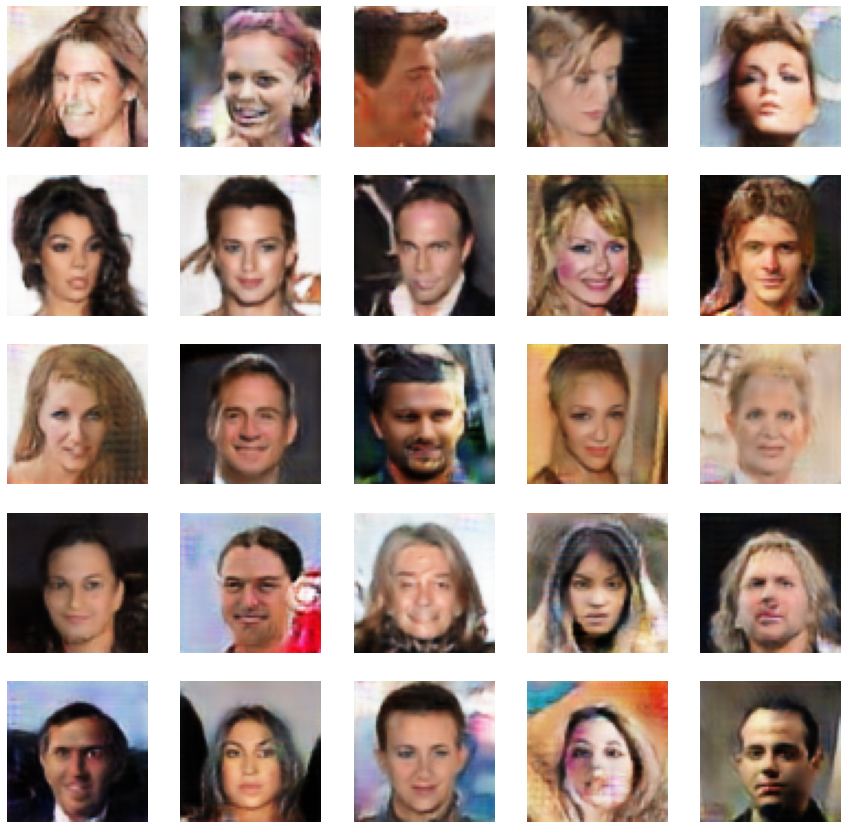

In [20]:
plt.figure(figsize=(15, 15))

image, label = next(iter(dataloader))

image, label = image.to(device), label.to(device).float()
target_domain = label.flip(dims=[0])
gen.train()
fake_image = gen(image, target_domain)



for index in range(fake_image.shape[0]):
    if index >= 25:
      break
    image = fake_image[index].detach().cpu()
    plt.subplot(5, 5, index + 1)
    plot_img(image, t_invnormalize)
plt.show()



  0%|          | 0/1 [00:00<?, ?it/s]

Target domain: Black_Hair


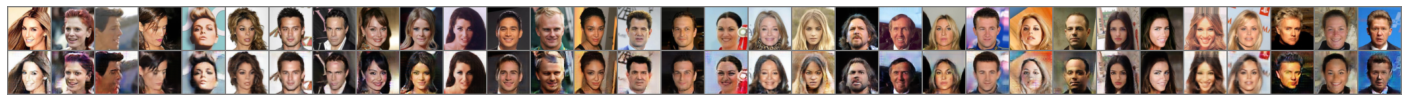

Target domain: Blond_Hair


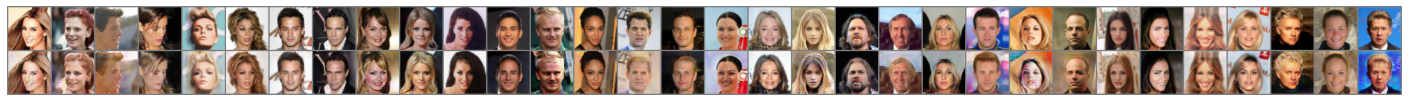

Target domain: Brown_Hair


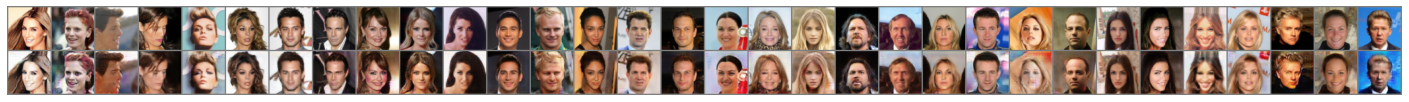

Target domain: Eyeglasses


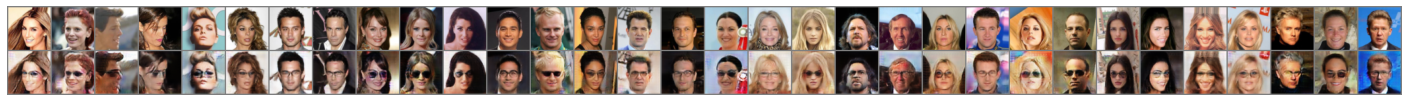

Target domain: Goatee


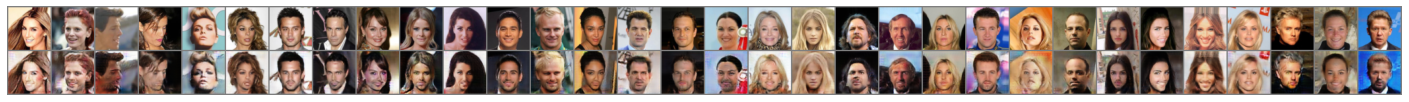

Target domain: Male


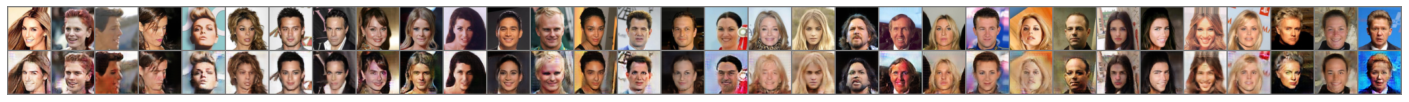

Target domain: Mustache


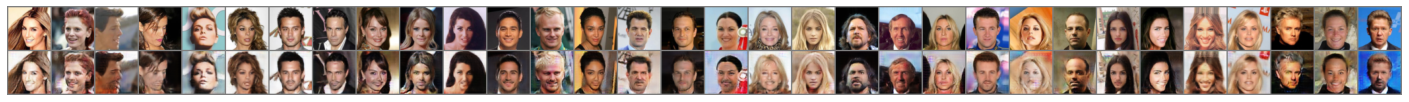

Target domain: Receding_Hairline


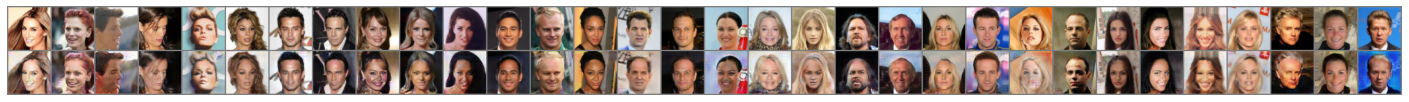

Target domain: Wearing_Hat


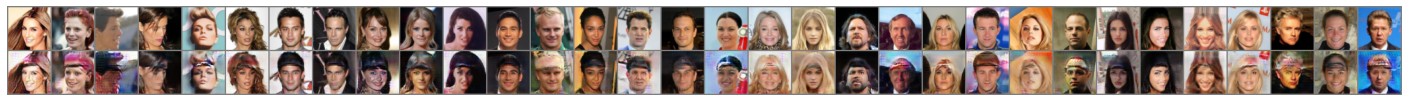

Target domain: Young


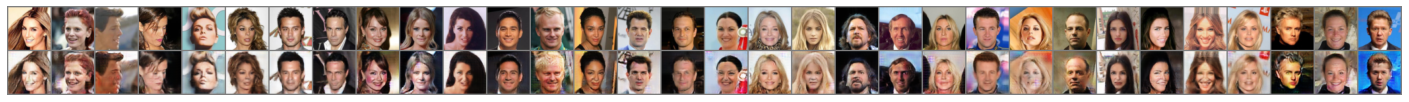

In [21]:
from torchvision.utils import make_grid

test_iters = 1
gen.eval()

iter_loader = iter(dataloader)

for i in trange(test_iters):
    x_real, y_real = next(iter_loader)
    y_real = y_real.float()

    x_real, y_real = x_real.to(device), y_real.to(device)

    for label_index in range(10):

        y_trg = y_real.clone()
        # print(y_trg[0])
        y_trg[:, label_index] = 1 - y_trg[:, label_index] # reverse
        # print(y_trg[0])
       

        print(f'Target domain: {attr_name[label_index]}')

        with torch.no_grad():
            x_fake = gen(x_real, y_trg)

        plt.figure(figsize=(25, 15))
        x_show = make_grid(torch.cat([x_real, x_fake], dim=0), nrow=x_fake.shape[0], normalize=False).detach().cpu()
        plot_img(x_show, t_invnormalize)
        plt.show()    


Во время обучения вы можете считать FID вашей модели, но для автопроверки мы решили использовать LPIPS — [Learned Perceptual Image Patch Similarity](https://arxiv.org/abs/1801.03924) как финальную метрику качества. 

Точную цифру для получения баллов за задание мы сообщим позже

In [22]:
!pip install git+https://github.com/S-aiueo32/lpips-pytorch.git -q

from lpips_pytorch import LPIPS
from itertools import islice
lpips = LPIPS().to(device)

def evaluate_model(dataloader, generator):
    values = []
    for x_real, label in tqdm(islice(dataloader, 100)):
        x_real, label = x_real.to(device), label.to(device).float()
        target_domain = label.flip(dims=[0])

        with torch.no_grad():
            x_fake = generator(x_real, target_domain)

        values.append(lpips(x_fake, x_real).squeeze().item() / x_fake.size(0))
    return np.mean(values)
    
evaluate_model(dataloader, gen)

    Running setup.py install for lpips-pytorch ... done
  DEPRECATION: lpips-pytorch was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://raw.githubusercontent.com/richzhang/PerceptualSimilarity/master/lpips/weights/v0.1/alex.pth" to /root/.cache/torch/hub/checkpoints/alex.pth


  0%|          | 0.00/5.87k [00:00<?, ?B/s]

0it [00:00, ?it/s]

0.08580775834619998